# CoverMyMeds Project 

##### Author: Andrew Castillo
#### Date: 4/26/2021

In this project, we examine the following topics: 

Part 1: Pharmacy Claim Data
- What does the formulary of each insurance company (payer) look like? 
- Predicting whether a prior authorization will be needed based upon pharmacy claims data.

Part 2: Prior Authorization Approval

- Analyzing which factors tend to influence whether PAs are likely to be approved or denied. 
- Predicting whether a prior authorization is likely to be approved based on data contained on the PA such as correct diagnosis, has already tried and failed a generic drug alternative, has health-related reasons not to take certain medications (contraindications), and claims data. 



In [1]:
#For data handling
import pandas as pd 
import numpy as np 

#For visualization 
import matplotlib.pyplot as plt
import seaborn as sns 

#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier

# Tree will be used to plot the decisiton tree
from sklearn import tree
# This is the actual out of the box algorithm
from sklearn.tree import DecisionTreeClassifier

#Scorers
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, roc_auc_score, make_scorer

from sklearn.model_selection import cross_val_score

#For handling categorical and missing data 
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

#Creating the train test split 
from sklearn.model_selection import train_test_split

# Part 1: Pharmacy Claim Data

Topics we investiate: 

- What does the formulary of each insurance company (payer) look like? 
- Predicting whether a prior authorization will be needed based upon pharmacy claims data.

In [2]:
#Gathering the dim_claims.csv file 
#This is a table containing pharmacy claim-level information.

dim_claims_filepath='/Users/andrewcastillo/Desktop/jupyter_notebook_work/covermymeds_intern_project/data/dim_claims.csv'
dim_claims_df=pd.read_csv(dim_claims_filepath)
dim_claims_df

,dim_claim_id,bin,drug,reject_code,pharmacy_claim_approved
0,1,417380,A,75.0,0
1,2,999001,A,NaN,1
2,3,417740,A,76.0,0
3,4,999001,A,NaN,1
4,5,417740,A,NaN,1
...,...,...,...,...,...
1335571,1335572,417740,C,75.0,0
1335572,1335573,999001,C,NaN,1
1335573,1335574,417380,C,70.0,0
1335574,1335575,999001,C,NaN,1


## dim_claims_df column key

Pharmacy_claimed_approved column

- 1:claim approved at the pharmacy and therefore no PA needed 
- 0:claim not approved and a PA is needed. 

Reject code

- 70: A code 70 implies that a drug is not covered by the plan and is not on formulary, and typically implies that another course of therapy should be pursued.  

- 75: A code 75 implies that a drug is on the formulary but does not have preferred status and requires a prior authorization (PA).  

- 76: A code 76 simply means that the drug is covered, but that the plan limitations have been exceeded, which means that the limitations on the number of fills for that medication has been met

### Cleaning the data 

In [3]:
#Gather information on the data frame 
dim_claims_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1335576 entries, 0 to 1335575
Data columns (total 5 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   dim_claim_id             1335576 non-null  int64  
 1   bin                      1335576 non-null  int64  
 2   drug                     1335576 non-null  object 
 3   reject_code              555951 non-null   float64
 4   pharmacy_claim_approved  1335576 non-null  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 50.9+ MB


In [4]:
#Seeing how many missing values there are 
dim_claims_df.isnull().sum()

dim_claim_id                    0
bin                             0
drug                            0
reject_code                779625
pharmacy_claim_approved         0
dtype: int64

In [5]:
#Checking that all approved pharmacy claims were associated with an nan code. 
df=dim_claims_df.loc[dim_claims_df.pharmacy_claim_approved==1, ['reject_code', 'pharmacy_claim_approved']]
df.reject_code.unique()

array([nan])

In [6]:
#Change the na values in the reject_code column to 0. I chose 0 because a no reject code (0) implies that we got
#the pharmacy claim approved. 
dim_claims_df['reject_code']=dim_claims_df.reject_code.fillna(0)
dim_claims_df.head(10)

,dim_claim_id,bin,drug,reject_code,pharmacy_claim_approved
0,1,417380,A,75.0,0
1,2,999001,A,0.0,1
2,3,417740,A,76.0,0
3,4,999001,A,0.0,1
4,5,417740,A,0.0,1
5,6,417740,A,0.0,1
6,7,999001,A,0.0,1
7,8,417740,A,0.0,1
8,9,999001,A,0.0,1
9,10,417380,A,75.0,0


In [7]:
#Which values are in the drug column. 
dim_claims_df.drug.unique()

array(['A', 'B', 'C'], dtype=object)

In [8]:
#Checking the unique values in the BIN section 
dim_claims_df.bin.unique()

array([417380, 999001, 417740, 417614])

In [9]:
#Function to turn numerical columns to categorical (for modeling purposes)
def to_categorical(data, categorical_cols):
    for col in data.columns:
        if col in categorical_cols:
            data[col] = data[col].astype('category')
    data.info()
    return data

In [10]:
categorical_cols = ['bin', 'drug', 'reject_code']
dim_claims_df=to_categorical(dim_claims_df, categorical_cols)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1335576 entries, 0 to 1335575
Data columns (total 5 columns):
 #   Column                   Non-Null Count    Dtype   
---  ------                   --------------    -----   
 0   dim_claim_id             1335576 non-null  int64   
 1   bin                      1335576 non-null  category
 2   drug                     1335576 non-null  category
 3   reject_code              1335576 non-null  category
 4   pharmacy_claim_approved  1335576 non-null  int64   
dtypes: category(3), int64(2)
memory usage: 24.2 MB


## Exploratory Data Analysis 

#### Question: Which insurance companies had the most approved pharmacy claims? Which drug was approved the most (numerically)? 

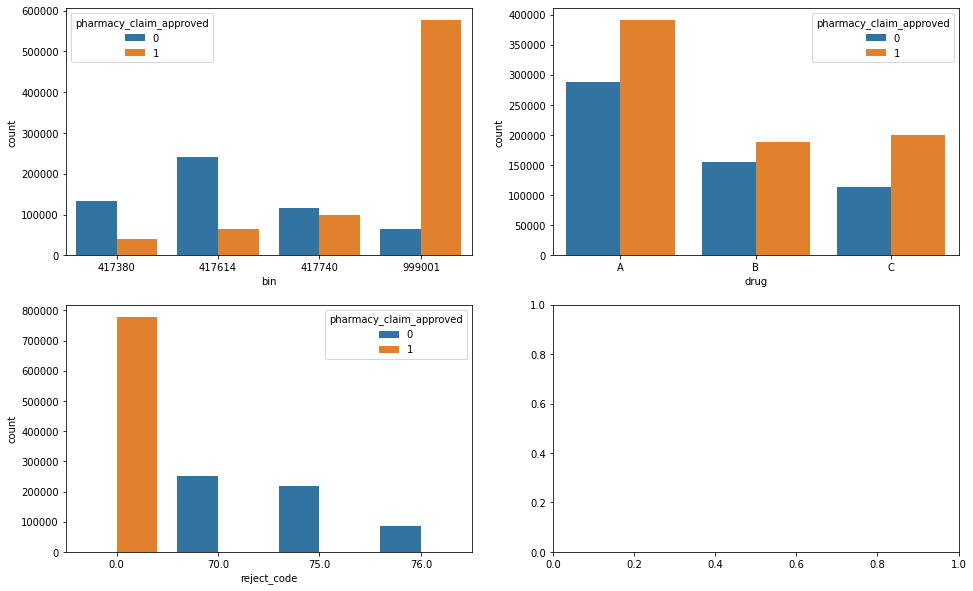

In [11]:
#Make count plots to see how which bins, drugs, reject codes appeared the most
fig, ax =plt.subplots(2,2, figsize=(16,10))
sns.countplot(x='bin', data=dim_claims_df, hue='pharmacy_claim_approved', ax=ax[0,0])
sns.countplot(x='drug', data=dim_claims_df, hue='pharmacy_claim_approved', ax=ax[0,1])
sns.countplot(x='reject_code', data=dim_claims_df, hue='pharmacy_claim_approved', ax=ax[1,0])
plt.savefig('bin_drug_reject_code.jpg')
plt.show()

#### As a whole, it looks like the insurance company with BIN 999001 had more approved pharmacy claims. Moreover, it looks like drug A was approved more often. It also looks like drug A was rejected most often as well. 

In [12]:
#Getting an exact count of the number of approved claims for each insurance provider. 
dim_claims_df.loc[dim_claims_df.pharmacy_claim_approved==1, ['bin']].value_counts()

bin   
999001    576667
417740     97951
417614     65055
417380     39952
dtype: int64

#### Question: Which rejection code seemed to appear the most with each drug? 

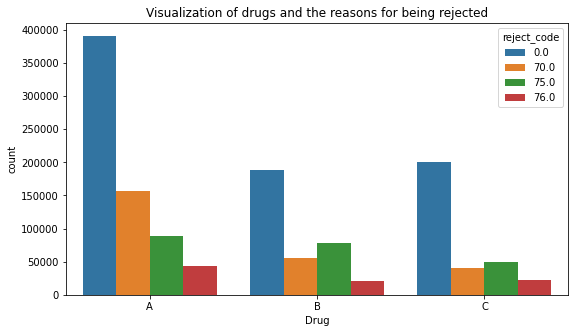

In [13]:
#Organizing the data by drug to see which rejection code appeared most with each drug. 
plt.figure(figsize = (9,5))

sns.countplot(x='drug', data=dim_claims_df, hue='reject_code')
plt.xlabel('Drug')
plt.title('Visualization of drugs and the reasons for being rejected')
plt.savefig('reject_code_with_drug.jpg')
plt.show()

Conclusion: 

- Drug A seems to not be covered by most insurance plans and looks like alternative options were often seeked there. (code 70)

- Drug B seems to have required PAs a good amount, primarily focused on no preferred status (code 75). 

- Drug C looks to have required many PAs relatively as well,  primarily focused on no preferred status (code 76). 

#### What about a scaled version of this? Relatively, how much did each code appear for each drug?

In [14]:
#Gathering the data frame for all reject codes associated with drug A 
df_A=dim_claims_df.loc[dim_claims_df.drug=='A', ['reject_code']]
df_A.value_counts()

reject_code
0.0            390991
70.0           156497
75.0            88486
76.0            43309
dtype: int64

In [15]:
#Getting the Rejection percentage data for Drug A (out of the total rejections made for drug A)
percentA=np.array([54, 31, 15])
    
df_A1= pd.DataFrame(percentA,
               
columns=['Percent Rejected'], index=['70', '75', '76'])

df_A1

,Percent Rejected
70,54
75,31
76,15


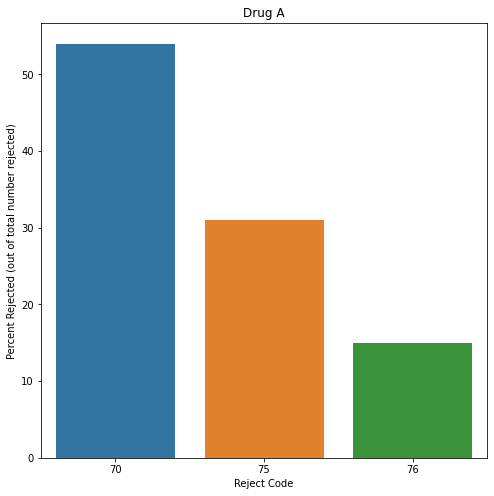

In [16]:
#Barchart for the previous data frame 
plt.figure(figsize = (8,8))

sns.barplot(x=df_A1.index, y=df_A1['Percent Rejected'])

plt.xlabel('Reject Code')
plt.ylabel('Percent Rejected (out of total number rejected)')
plt.title('Drug A')
plt.show()

Out of the total 679,283 claims made for drug A, about 58% percent of them had their pharmacy claims approved. Furthermore, of the 288,292 rejections made by for Drug A, about 54% of those rejections had rejection code 70, 31% had rejection code 75, and 15% had rejection code 76. Hence, if a patient got rejected for drug A, it was more than likely because the drug was not covered on the insurance providers formulary. 

In [17]:
#Gathering the data frame for all reject codes associated with drug B
df_B=dim_claims_df.loc[dim_claims_df.drug=='B', ['reject_code']]
df_B.value_counts()

reject_code
0.0            188238
75.0            78686
70.0            55035
76.0            20791
dtype: int64

In [18]:
#Getting the Rejection percentage data for Drug B (out of the total rejections made for drug B)
percentB=np.array([36, 51, 13])
    
df_B1= pd.DataFrame(percentB,
               
columns=['Percent Rejected'], index=['70', '75', '76'])

df_B1

,Percent Rejected
70,36
75,51
76,13


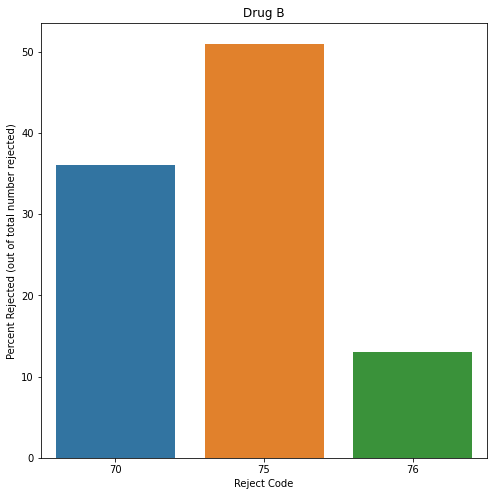

In [19]:
#Barchart for the previous data frame 
plt.figure(figsize = (8,8))

sns.barplot(x=df_B1.index, y=df_B1['Percent Rejected'])

plt.xlabel('Reject Code')
plt.ylabel('Percent Rejected (out of total number rejected)')
plt.title('Drug B')
plt.show()

Out of the total 342,750 claims made for drug B, about 55% percent of them had their pharmacy claims approved. Furthermore, out of the 154,512 rejections made for Drug B, about 36% of those rejections had rejection code 70, 51% had rejection code 75, and 13% had rejection code 76. Hence, if a patient got rejected for drug B, it was more than likely because the drug had no preferred status from the insurance company. 

In [20]:
#Gathering the data frame for all reject codes associated with drug C
df_C=dim_claims_df.loc[dim_claims_df.drug=='C', ['reject_code']]
df_C.value_counts()

reject_code
0.0            200396
75.0            50179
70.0            40674
76.0            22294
dtype: int64

In [21]:
#Getting the Rejection percentage data for Drug C (out of the total rejections made for drug C)
percentC=np.array([36, 44, 20])
    
df_C1= pd.DataFrame(percentC,
               
columns=['Percent Rejected'], index=['70', '75', '76'])

df_C1

,Percent Rejected
70,36
75,44
76,20


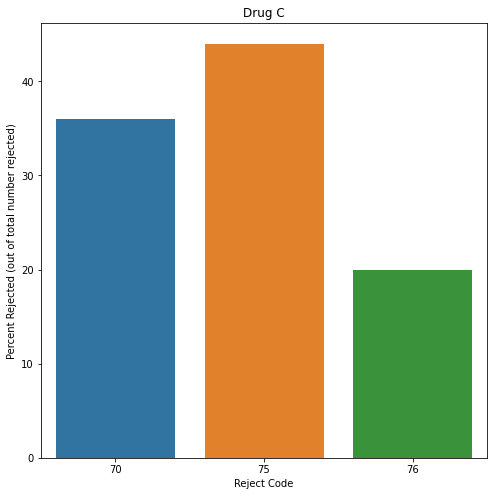

In [22]:
#Barchart for the previous data frame 
plt.figure(figsize = (8,8))

sns.barplot(x=df_C1.index, y=df_C1['Percent Rejected'])

plt.xlabel('Reject Code')
plt.ylabel('Percent Rejected (out of total number rejected)')
plt.title('Drug C')
plt.show()

Out of the total 313,543 claims made for drug C, about 64% percent of them had their pharmacy claims approved. Furthermore, out of the 113,147 rejections made for Drug C, about 36% of those rejections had rejection code 70, 44% had rejection code 75, and 20% had rejection code 76. Hence, if a patient got rejected for drug C, it was more than likely because the drug had no preferred status from the insurance company. 

Across all three drugs, it seems that rejection code 76 was not the most prevalent reason for the claim being rejected. If a claim was rejected, it was quite often because either the drug was not covered or on the formulary or a prior authorization was needed. 

### Analyze the formulary for each payer. 

In [23]:
#Create new data frames relating the specific insurance provider and the drug and 
#approved claim 
df_p380=dim_claims_df[dim_claims_df.bin==417380][['drug', 'pharmacy_claim_approved']]
df_p614=dim_claims_df[dim_claims_df.bin==417614][['drug', 'pharmacy_claim_approved']]
df_p740=dim_claims_df[dim_claims_df.bin==417740][['drug', 'pharmacy_claim_approved']]
df_p001=dim_claims_df[dim_claims_df.bin==999001][['drug', 'pharmacy_claim_approved']]

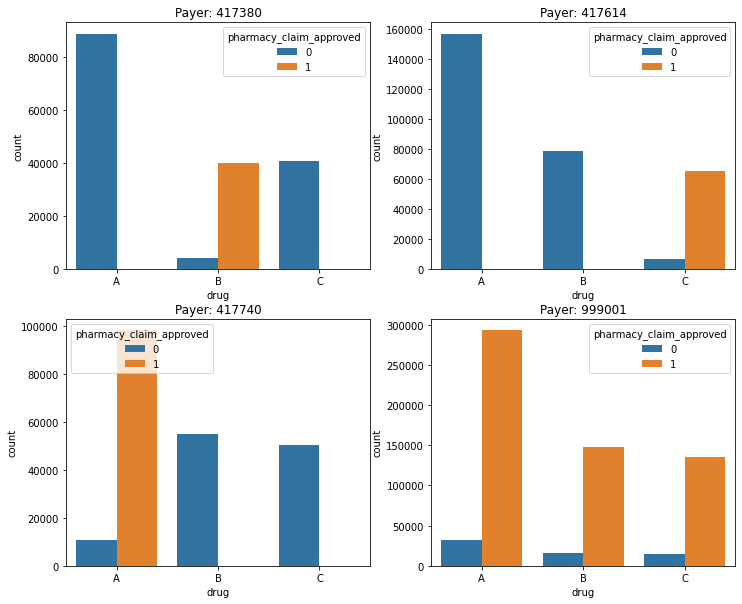

In [24]:
#Get an idea of each formulary
fig, ax =plt.subplots(2,2, figsize=(12,10))
sns.countplot(x='drug', data=df_p380, hue='pharmacy_claim_approved', ax=ax[0,0])
ax[0, 0].set_title('Payer: 417380')
sns.countplot(x='drug', data=df_p614, hue='pharmacy_claim_approved', ax=ax[0,1])
ax[0, 1].set_title('Payer: 417614')
sns.countplot(x='drug', data=df_p740, hue='pharmacy_claim_approved', ax=ax[1,0])
ax[1, 0].set_title('Payer: 417740')
sns.countplot(x='drug', data=df_p001, hue='pharmacy_claim_approved', ax=ax[1,1])
plt.title('Payer: 999001')
plt.savefig('formulary_for_payer.jpg')
plt.show()

The above count plots show us the following information about each insurance company: 

- Payer 417380: Only approved the drug B and seems to completely reject drugs A and C. 

- Payer 417614: Only approved the drug C and seems to completely reject drugs A and B. 

- Payer 417470: Only approved the drug A and seems to completely reject drugs B and C.

- Payer 999001: Was much more open to approving medication of all types. 

With this information in hand, can we get an idea of why the drugs were rejected by the payer? This will allow us to gather more information on the formulary. 

#### Create pivot tables to analyze the reject codes for the non-approved claims within each insurance provider and get a better idea of the formulary. 

In [25]:
#Pivot table for insurance provider with BIN 417380
df_p3801=dim_claims_df[dim_claims_df.bin==417380][['drug', 'pharmacy_claim_approved', 'reject_code']]
pivot_3801 = pd.pivot_table(data=df_p3801, index=['drug'], columns=['reject_code'], values=['pharmacy_claim_approved'], aggfunc='count')
pivot_3801

pharmacy_claim_approved                    
reject_code                     0.0   70.0   75.0  76.0
drug                                                   
A                                 0      0  88486     0
B                             39952      0      0  4419
C                                 0  40674      0     0

For insurance company with BIN 417380: 
- Drug A was rejected primarily for not having a preferred status (reject code 75).  
- Drug B while approved, was only rejected for exceeding plan limitations (reject code 76). 
- Drug C was primarily rejected for not being covered by the plan and not on the formulary (reject code 70). 
- Formulary for this payer contains drug B and A (no preferred status) but not C. 

In [26]:
#Pivot table for insurance provider with BIN 417614
df_p6141=dim_claims_df[dim_claims_df.bin==417614][['drug', 'pharmacy_claim_approved', 'reject_code']]
pivot_6141 = pd.pivot_table(data=df_p6141, index=['drug'], columns=['reject_code'], values=['pharmacy_claim_approved'], aggfunc='count')
pivot_6141

pharmacy_claim_approved                     
reject_code                     0.0    70.0   75.0  76.0
drug                                                    
A                                 0  156497      0     0
B                                 0       0  78686     0
C                             65055       0      0  7085

For insurance company with BIN 417380: 
- Drug A was primarily rejected for not being covered by the plan and not on the formulary (reject code 70). 
- Drug B was rejected primarily for not having a preferred status (reject code 75).  
- Drug C while approved, was only rejected for exceeding plan limitations (reject code 76).
- Formulary for this payer contains drug C and B (no preferred status) but not A. 

In [27]:
#Pivot table for insurance provider with BIN 417740
df_p7401=dim_claims_df[dim_claims_df.bin==417740][['drug', 'pharmacy_claim_approved', 'reject_code']]
pivot_7401 = pd.pivot_table(data=df_p7401, index=['drug'], columns=['reject_code'], values=['pharmacy_claim_approved'], aggfunc='count')
pivot_7401

pharmacy_claim_approved                     
reject_code                     0.0   70.0   75.0   76.0
drug                                                    
A                             97951      0      0  10817
B                                 0  55035      0      0
C                                 0      0  50179      0

For insurance company with BIN 417740: 
- Drug A while approved, was only rejected for exceeding plan limitations (reject code 76).
- Drug B was primarily rejected for not being covered by the plan and not on the formulary (reject code 70).
- Drug C was rejected primarily for not having a preferred status (reject code 75). 
- Formulary for this payer contains drug A and C (no preferred status) but not B. 

In [28]:
#Pivot table for insurance provider with BIN 999001
df_p0011=dim_claims_df[dim_claims_df.bin==999001][['drug', 'pharmacy_claim_approved', 'reject_code']]
pivot_0011 = pd.pivot_table(data=df_p0011, index=['drug'], columns=['reject_code'], values=['pharmacy_claim_approved'], aggfunc='count')
pivot_0011

pharmacy_claim_approved                 
reject_code                     0.0 70.0 75.0   76.0
drug                                                
A                            293040    0    0  32492
B                            148286    0    0  16372
C                            135341    0    0  15209

For insurance company with BIN 999001: 
- Drug A, B, and C while approved were only rejected for exceeding plan limitations (but still are covered). 
- Formulary for this payer contains all drugs!  


## Modeling Phase : Predicting whether a PA is going to be needed based on pharmacy claims data. 

In [29]:
#Remind ourselves of the data 
dim_claims_df.head(7)

,dim_claim_id,bin,drug,reject_code,pharmacy_claim_approved
0,1,417380,A,75.0,0
1,2,999001,A,0.0,1
2,3,417740,A,76.0,0
3,4,999001,A,0.0,1
4,5,417740,A,0.0,1
5,6,417740,A,0.0,1
6,7,999001,A,0.0,1


In [30]:
#Feature Matrix 
#Dropping reject_code to avoid a duplicate of the target variable. 
X=dim_claims_df.drop(['pharmacy_claim_approved', 'reject_code'], axis=1)

#Target Variable
y=dim_claims_df.pharmacy_claim_approved

In [31]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1335576 entries, 0 to 1335575
Data columns (total 3 columns):
 #   Column        Non-Null Count    Dtype   
---  ------        --------------    -----   
 0   dim_claim_id  1335576 non-null  int64   
 1   bin           1335576 non-null  category
 2   drug          1335576 non-null  category
dtypes: category(2), int64(1)
memory usage: 12.7 MB


In [32]:
#Create the train-test split 
X_train,X_val,y_train,y_val = train_test_split(X,
                                                y,
                                                shuffle = True,
                                                stratify = y,
                                                train_size=0.70,
                                                random_state = 614)

X_val_2=X_val.copy()
X_train=X_train.drop('dim_claim_id', axis=1)
X_val=X_val.drop('dim_claim_id', axis=1)

In [33]:
#Viewing to make sure that the training data did indeed drop the columns we needed.  
X_train.head()

,bin,drug
828130,417614,A
217502,999001,A
146462,999001,A
229342,999001,C
913971,999001,C


In [34]:
#Function we will use to get model metrics. 
def get_model_scores(model, X_t, y_t, X_v, y_v): 
    """Get accuracy, precision, recall, AUC, scores for designated model"""

    # Fit the data 
    model.fit(X_t, y_t)

    # Get predictions
    y_pred = model.predict(X_v)
    
    #Accuracy Score
    accuracy=accuracy_score(y_v, y_pred)
    
    #Precision Score
    precision=precision_score(y_v, y_pred)
    
    #Recall Score
    recall=recall_score(y_v, y_pred)
    
    #AUC Score
    y_prob=model.predict_proba(X_v)
    
    auc_score=roc_auc_score(y_v,y_prob[:,1])
    
    
    scores=np.array([accuracy, precision, recall, auc_score])
    
    df = pd.DataFrame(scores,
               
                      columns=['Scores'], index=['Accuracy', 'Precision', 'Recall', 'AUC'])
    return df

In [35]:
#Preprocess by one hot encoding 
categorical_cols_OH=['drug', 'bin']
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[categorical_cols_OH]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_val[categorical_cols_OH]))

#Put the columns names back 
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_val.index

# Remove categorical columns (will replace with one-hot encoding)
#numerical columns in X_train and X_valid 
num_X_train = X_train.drop(categorical_cols_OH, axis=1)
num_X_valid = X_val.drop(categorical_cols_OH, axis=1)

# Add one-hot encoded columns to numerical features. These are our testing features 
X_train_OH = pd.concat([num_X_train, OH_cols_train], axis=1)
X_valid_OH = pd.concat([num_X_valid, OH_cols_valid], axis=1)

In [36]:
X_train_OH.head(10)

,0,1,2,3,4,5,6
828130,1.0,0.0,0.0,0.0,1.0,0.0,0.0
217502,1.0,0.0,0.0,0.0,0.0,0.0,1.0
146462,1.0,0.0,0.0,0.0,0.0,0.0,1.0
229342,0.0,0.0,1.0,0.0,0.0,0.0,1.0
913971,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1324805,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1032431,1.0,0.0,0.0,0.0,0.0,0.0,1.0
858213,1.0,0.0,0.0,0.0,0.0,0.0,1.0
907597,1.0,0.0,0.0,0.0,1.0,0.0,0.0
340025,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [37]:
##Beginning the actual model testing. We will use the default settings. 

#Given how sparse the data is as well as the binary nature of the features 
#it seems like a random_forest is one of the more appropriate models to use in this situation. 
random_forest =RandomForestClassifier(random_state=0)

print(f'{random_forest} scores:')
get_model_scores(random_forest, X_train_OH, y_train, X_valid_OH, y_val)

RandomForestClassifier(random_state=0) scores:


,Scores
Accuracy,0.935039
Precision,0.899860
Recall,1.000000
AUC,0.921841


Model seems to do really well on the default hyperparameters, so we will just check across the max_depth. 

### Use GridSearch to find the best possible model. 

In [38]:
#GridSearching for the best possible parameter on the max_depth. 

from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':range(5, 11, 5)}

gs=GridSearchCV(random_forest, parameters, scoring='precision', cv=5)

gs.fit(X_train_OH, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': range(5, 11, 5)}, scoring='precision')

In [39]:
#Try and find the best model to increase the precision score across the depth parameters. It did well enough 
#on the n_esitmators data point at 100. 

print(f"The best Random Forest Classifier Precision Score: {gs.best_score_}\n")

print(f"The best Random Forest Classifier Model: {gs.best_estimator_}")

The best Random Forest Classifier Precision Score: 0.9004033851795175

The best Random Forest Classifier Model: RandomForestClassifier(max_depth=5, random_state=0)


It looks like the model performs better with a max_depth hyperparameter equal to 5 so we will use that model and see if the corresponding recall and accuracy scores are better too using cross validation. 

### Cross Validate the data across the metrics on the best model found. 

In [40]:
#Convert accuracy, recall, and precision scores to metrics that will be used in cross validation. 
accuracy_metric=make_scorer(accuracy_score)
recall_metric=make_scorer(recall_score)
precision_metric=make_scorer(precision_score)

rf_clf=RandomForestClassifier(max_depth=5, random_state=0)

print(f'{random_forest} scores:\n')
accuracy_scores=cross_val_score(rf_clf, X_train_OH, y_train,
                              cv=5,
                              scoring=accuracy_metric)
recall_scores=cross_val_score(rf_clf, X_train_OH, y_train,
                              cv=5,
                              scoring=recall_metric)
precision_scores=cross_val_score(rf_clf, X_train_OH, y_train,
                              cv=5,
                              scoring=precision_metric)
print(f"Random Forest Classifier accuracy scores: {accuracy_scores}")
print(f"Random Forest Classifier mean accuracy score: {np.mean(accuracy_scores)}\n")
print(f"Random Forest Classifier precision scores: {precision_scores}")
print(f"Random Forest Classifier mean precision score: {np.mean(precision_scores)}\n")
print(f"Random Forest Classifier recall scores: {recall_scores}")
print(f"Random Forest Classifier mean recall score: {np.mean(recall_scores)}\n")

RandomForestClassifier(random_state=0) scores:

Random Forest Classifier accuracy scores: [0.93535172 0.93525545 0.93616464 0.93535672 0.93502514]
Random Forest Classifier mean accuracy score: 0.935430734012396

Random Forest Classifier precision scores: [0.90029282 0.90015999 0.9014238  0.90030025 0.89984006]
Random Forest Classifier mean precision score: 0.9004033851795175

Random Forest Classifier recall scores: [1. 1. 1. 1. 1.]
Random Forest Classifier mean recall score: 1.0



From cross validation, it looks like the model is performing about the same across all metrics through each fold in the cross validation process.

### Confusion Matrix and Classification Report

In [41]:
#Print the classification report 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
rf_clf.fit(X_train_OH, y_train)
y_pred=rf_clf.predict(X_valid_OH)
conf_matrix = confusion_matrix(y_val, y_pred)
print("confusion matrix")
print(conf_matrix)
print("-------------------------------------------")
print(classification_report(y_val,y_pred))

confusion matrix
[[140757  26028]
 [     0 233888]]
-------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.84      0.92    166785
           1       0.90      1.00      0.95    233888

    accuracy                           0.94    400673
   macro avg       0.95      0.92      0.93    400673
weighted avg       0.94      0.94      0.93    400673



#### Gathering feature importance

In [42]:
#Finding the feature importance in the random forest classifier model. 
names = []
scores = []
for name, score in zip(X_valid_OH.columns,rf_clf.feature_importances_):
    names.append(name)
    scores.append(np.round(score,4))
    
score_df = pd.DataFrame({'feature':names,'importance_score':scores})

score_df.sort_values('importance_score',ascending=False)

,feature,importance_score
6,6,0.3426
4,4,0.1797
0,0,0.1126
3,3,0.1001
5,5,0.0929
2,2,0.0923
1,1,0.0798


In [43]:
#Viewing the validation matrix
X_valid_OH.head(7)

,0,1,2,3,4,5,6
355791,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1025245,0.0,1.0,0.0,0.0,0.0,1.0,0.0
775418,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1189929,1.0,0.0,0.0,1.0,0.0,0.0,0.0
427539,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1048011,1.0,0.0,0.0,0.0,1.0,0.0,0.0
593078,0.0,1.0,0.0,0.0,0.0,0.0,1.0


The main feature importance seems to be coming from column 6. This column was one hot encoded from the drug C column. 

#### Visual representation of the AUC score with ROC curve. 

- Area under the curve gives us an understanding of the AUC measurement. 
- The ROC is a probability curve and the AUC measures the ability of the model to distinguish between 0 and 1. 

In [44]:
# The first column is probability of being class 0
# the second is probability of being class 1
# import the function from sklearn
from sklearn.metrics import roc_auc_score
y_prob_pa=rf_clf.predict_proba(X_train_OH)

In [45]:
# put in the true classes along with the 
# probability scores.
roc_auc_score(y_train,y_prob_pa[:, 1])

0.9228266491430455

In [46]:
# import the roc function from sklearn
from sklearn.metrics import roc_curve

# calculate fpr and tpr
# you put in the training data
# and the predicted probabilites
# it returns the fpr, tpr, and corresponding
# cutoffs
fpr_pa, tpr_pa, cutoffs_pa = roc_curve(y_train,y_prob_pa[:,1])

Text(0, 0.5, 'True Positive Rate')

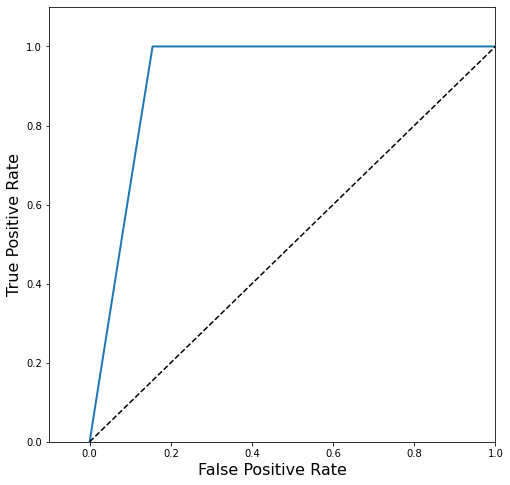

In [47]:
# plot the roc curve
plt.figure(figsize=(8,8))

# plot the curve
plt.plot(fpr_pa,tpr_pa,linewidth=2)

# plot what you'd get with random guessing
plt.plot([0,1],[0,1],'k--')

plt.axis([-0.1,1,0,1.1])

plt.xlabel("False Positive Rate",fontsize=16)
plt.ylabel("True Positive Rate",fontsize=16)

#Note: True Positive Rate is the same thing as sensitivity (i.e. recall)
#False positive rate is 1-specificity

### Convert validation information and prediction to a CSV 

In [48]:
y_pred_pa=rf_clf.predict(X_valid_OH)

In [49]:
#Let's now convert this information into a csv for viewing.
X_val_2['model_pa_claim_predictions']=y_pred_pa
pd.DataFrame(X_val_2).to_csv("pa_pharmacy_claim_predictions.csv", index = None)

In [50]:
#See the prediction for the specific prior authorization patient. 
pd.read_csv('pa_pharmacy_claim_predictions.csv')

,dim_claim_id,bin,drug,model_pa_claim_predictions
0,355792,999001,B,1
1,1025246,417740,B,0
2,775419,417614,B,0
3,1189930,417380,A,0
4,427540,417380,A,0
...,...,...,...,...
400668,844656,417614,C,1
400669,320320,417380,C,0
400670,1325922,417614,A,0
400671,1255262,999001,A,1


# Part 2: Prior Authorization Approval  

Topics we investigate: 

- Analyzing which factors tend to influence whether PAs are likely to be approved or denied.
- Predicting whether a prior authorization is likely to be approved based on data contained on the PA such as correct diagnosis, has already tried and failed a generic drug alternative, has health-related reasons not to take certain medications (contraindications), and claims data. 



In [51]:
#Gathering the dim_pa.csv file 
#This is a table containing pharmacy claim-level information.

dim_pa_filepath='/Users/andrewcastillo/Desktop/jupyter_notebook_work/covermymeds_intern_project/data/dim_pa.csv'
dim_pa_df=pd.read_csv(dim_pa_filepath)
dim_pa_df

,dim_pa_id,correct_diagnosis,tried_and_failed,contraindication,pa_approved
0,1,1,1,0,1
1,2,1,0,0,1
2,3,0,0,1,1
3,4,1,1,0,1
4,5,0,1,0,1
...,...,...,...,...,...
555946,555947,1,0,1,0
555947,555948,1,0,1,1
555948,555949,1,1,1,1
555949,555950,1,0,0,1


## dim_pa_df column key

pa_approved
- 1: PA approved by payer 
- 0:PA not approved by payer

correct_diagnosis 
- 1:Care provider indicated that patient has the correct diagnosis for the associated drug 
- 0:Care provider did not indicate that patient has the correct diagnosis for the associated drug

tried_and_failed
- 1:Care provider indicated that patient has tried and failed generic drug alternatives 
- 0:Care provider indicated that patient has not tried and failed generic drug alternatives 

contraindication (def=health-related reasons not to take certain medications)
- 1: Information provided by the care provider indicating that the patient has an associated contraindication for the medication requested.  
- 0: Information provided by the care provider indicating that the patient does not have an associated contraindication for the medication requested. 

### Exploratory Data Analysis (EDA)

- The EDA was performed only on the data contained on the prior authorization. 

In [52]:
#Checking the data frame to see data types and if there are any missing values. 
dim_pa_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555951 entries, 0 to 555950
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   dim_pa_id          555951 non-null  int64
 1   correct_diagnosis  555951 non-null  int64
 2   tried_and_failed   555951 non-null  int64
 3   contraindication   555951 non-null  int64
 4   pa_approved        555951 non-null  int64
dtypes: int64(5)
memory usage: 21.2 MB


In [53]:
#Double checking to see if there are any missing values. 
dim_pa_df.isnull().sum()

dim_pa_id            0
correct_diagnosis    0
tried_and_failed     0
contraindication     0
pa_approved          0
dtype: int64

#### Question: What is the relationship between the correct diagnosis, tried and failed, and contraindication and the prior authorization being approved? 

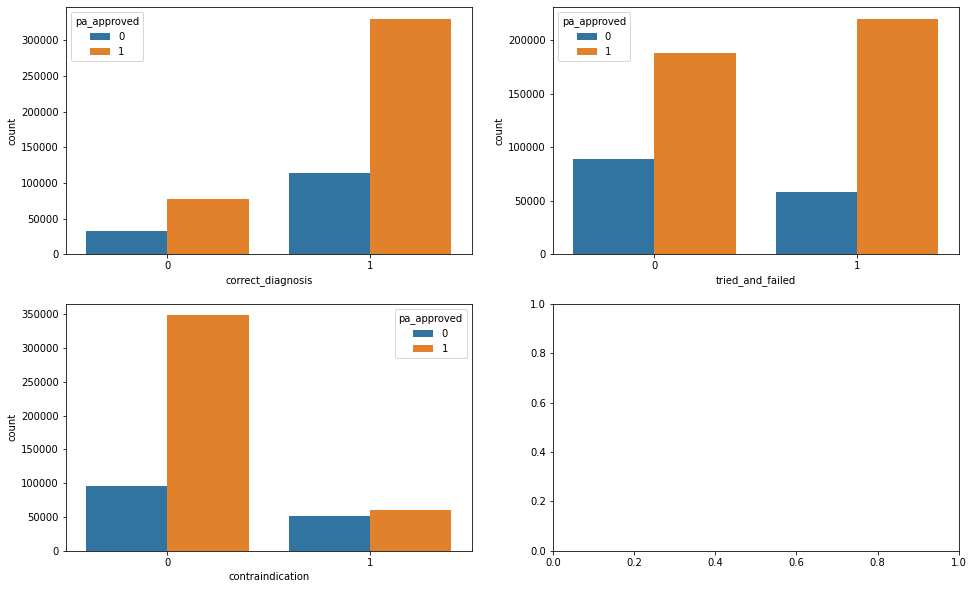

In [54]:
#Make count plots to see how which bins, drugs, reject codes appeared the most
fig, ax =plt.subplots(2,2, figsize=(16,10))
sns.countplot(x='correct_diagnosis', data=dim_pa_df, hue='pa_approved', ax=ax[0,0])
sns.countplot(x='tried_and_failed', data=dim_pa_df, hue='pa_approved', ax=ax[0,1])
sns.countplot(x='contraindication', data=dim_pa_df, hue='pa_approved', ax=ax[1,0])
plt.show()

Conclusion: 

- From looking at the relative plots, if the patient has the correct diagnosis, the prior authorization was more than likely to be approved. 
- Whether you tried and failed a generic alternative it was about even for a prior authorization to be approved. 
- If there is no contraindication (health-related reason to not take the requested medication), the prior authorization is more than likely to be approved. In other words, if the patient has a health related reason to not take the requested medication (indicated by the payer), the prior authorization would more than likely not be approved. 

#### Question: Of the people who have or have not tried and failed a generic alternative, how many of them had contraindications or a correct diagnosis and got their PA approved? 
- This may help us better understand why the prior authorization acceptance seems balanced for the tried and failed column.  In particular, this will help us analyze which factors tend to influence whether PAs are likely to be approved or denied.

In [55]:
#Try and gather a better understanding of the people who tried and failed. Was there a relationship between them 
#the contraindication as well as correct_diagonsis. 
df_tf0=dim_pa_df[dim_pa_df.tried_and_failed==0][['correct_diagnosis', 'pa_approved']]
df_tf1=dim_pa_df[dim_pa_df.tried_and_failed==1][['correct_diagnosis', 'pa_approved']]
df_tf2=dim_pa_df[dim_pa_df.tried_and_failed==0][['contraindication', 'pa_approved']]
df_tf3=dim_pa_df[dim_pa_df.tried_and_failed==1][['contraindication', 'pa_approved']]

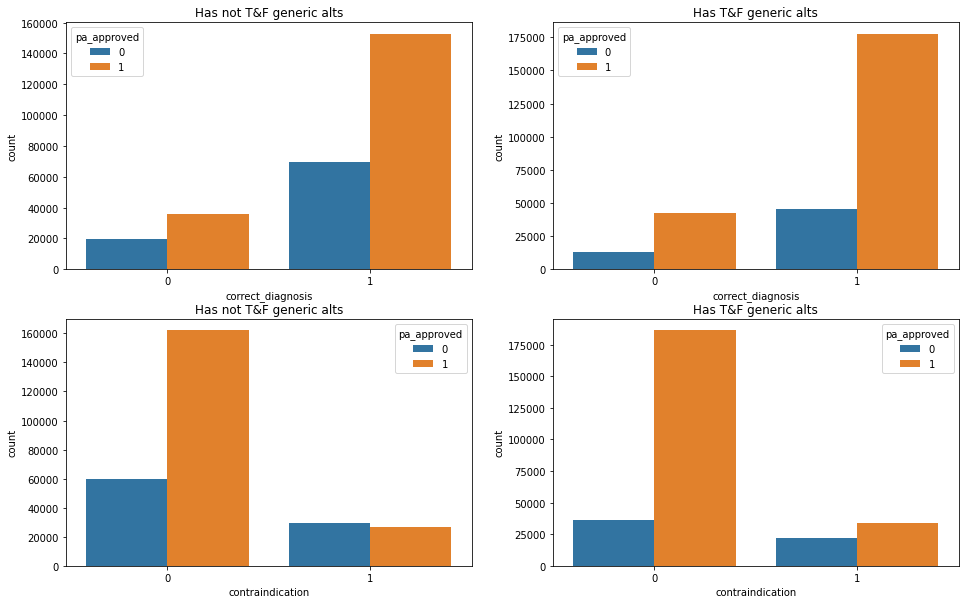

In [56]:
#Plot the count plots 
fig, ax =plt.subplots(2,2, figsize=(16,10))
sns.countplot(x='correct_diagnosis', data=df_tf0, hue='pa_approved', ax=ax[0,0])
ax[0, 0].set_title('Has not T&F generic alts' )
sns.countplot(x='correct_diagnosis', data=df_tf1, hue='pa_approved', ax=ax[0,1])
ax[0, 1].set_title('Has T&F generic alts')
sns.countplot(x='contraindication', data=df_tf2, hue='pa_approved', ax=ax[1,0])
ax[1, 0].set_title('Has not T&F generic alts' )
sns.countplot(x='contraindication', data=df_tf3, hue='pa_approved', ax=ax[1,1])
plt.title('Has T&F generic alts')
plt.savefig('factors_influence_pas.jpg')
plt.show()

Observations on these countplots:  

- From these visualizations, it seems that whether or not a patient has tried and failed generic drug alternatives, it looks like if they had the correct diagnosis, the prior authorization was more than likely to be approved. 

- Moreover, whether or not a patient has tried and failed generic drug alternatives, if the patient did not have a health related reason to not take the requested medication (non contraindication), the prior authorization was more than likely approved. 

#### Question: Did the correct diagnosis and/or contraindication have more of an influence on the PA approval? 

### Use pivot tables to analyze which of these two observations (potentially both) are correct. 

In [57]:
#Pivot table combining all the information for correct_diagnosis, contraindication, and 
#have not tried and failed a generic drug alternative 
df_tf01=dim_pa_df[dim_pa_df.tried_and_failed==0][['correct_diagnosis','contraindication','pa_approved']]
pivot_tf01 = pd.pivot_table(data=df_tf01, index=['correct_diagnosis', 'contraindication'], values=['pa_approved'], aggfunc='sum')
pivot_tf01

pa_approved
correct_diagnosis contraindication             
0                 0                       30853
                  1                        4968
1                 0                      131135
                  1                       21488

In [101]:
#Checking that we have the correct number of pa approvals for those who have not
#tried and failed generic alternatives. 
dim_pa_df[dim_pa_df.tried_and_failed==0]['pa_approved'].value_counts()

1    188444
0     89109
Name: pa_approved, dtype: int64

From this pivot table we can conclude that from those patients that did not try and fail generic drug alternatives: 
- 30,853 PA approvals were given to those patients who did not have a correct diagnosis and no contraindication for the requested medication. 
- 4,968 PA approvals were given to those patients who did not have a correct diagnosis and a contraindication for the requested medication. 
- 131,135 PA approvals were given to those patients who did have the correct diagnosis and no contraindication for the requested medication. 
- 21,488 PA approvals were given to those patients who did have the correct diagnosis and a contraindication for the requested medication.

In [59]:
#Pivot table combining all the information for correct_diagnosis, contraindication, and have 
#tried and failed a generic drug alternative 
df_tf11=dim_pa_df[dim_pa_df.tried_and_failed==1][['correct_diagnosis','contraindication','pa_approved']]
pivot_tf11 = pd.pivot_table(data=df_tf11, index=['correct_diagnosis', 'contraindication'], values=['pa_approved'], aggfunc='sum')
pivot_tf11

pa_approved
correct_diagnosis contraindication             
0                 0                       36091
                  1                        6300
1                 0                      150210
                  1                       27274

In [102]:
#Checking that we have the correct number of pa approvals for those who have tried and 
#failed generic alternatives.
dim_pa_df[dim_pa_df.tried_and_failed==1]['pa_approved'].value_counts()

1    219875
0     58523
Name: pa_approved, dtype: int64

From this pivot table we can conclude that from those patients that did try and fail generic drug alternatives: 
- 36,091 PA approvals were given to those patients who did not have a correct diagnosis and no contraindication for the requested medication. 
- 6,300 PA approvals were given to those patients who did not have a correct diagnosis and a contraindication for the requested medication. 
- 150,210 PA approvals were given to those patients who did have the correct diagnosis and no contraindication for the requested medication. 
- 27274 PA approvals were given to those patients who did have the correct diagnosis and a contraindication for the requested medication

### Using a heat map to find some potential correlation between the features and the approved prior authorization. 

In [99]:
#Correlation matrix to see the relationship between the predicting features and the pa_approved column. 
df_pa=dim_pa_df.drop('dim_pa_id', axis=1)
df_pa.corr()

,correct_diagnosis,tried_and_failed,contraindication,pa_approved
correct_diagnosis,1.000000,0.000531,-0.000747,0.035889
tried_and_failed,0.000531,1.000000,0.000307,0.125490
contraindication,-0.000747,0.000307,1.000000,-0.223283
pa_approved,0.035889,0.125490,-0.223283,1.000000


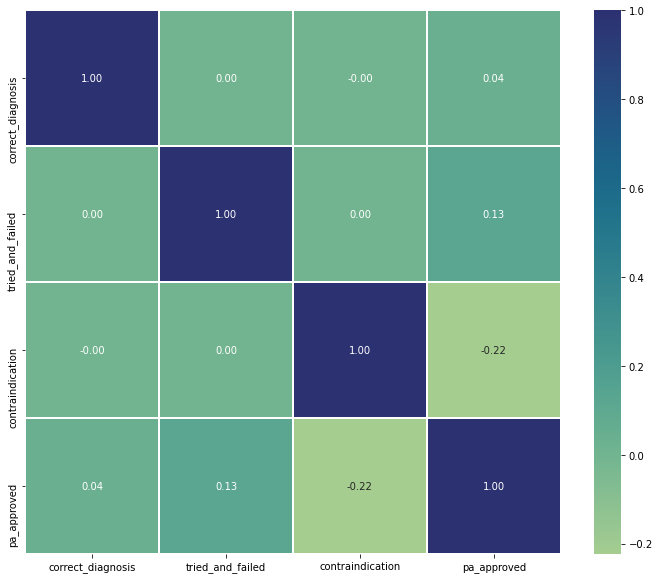

In [100]:
plt.figure(figsize=(12,10))
cmap=sns.color_palette("crest", as_cmap=True)
sns.heatmap(df_pa.corr(), annot=True, fmt = ".2f", linewidth=0.5, cmap=cmap)
plt.show()

- It looks like the strongest relationship is between the tried_and_failed as well as contraindication features and the prior authorization being approved. 
- There does not seem to be much correlation between the correct_diagnosis and pa_approved column.

#### Conclusion on which factors tend to influence the approval of a prior authorization (at this point based on prior authorization data): 
- Due to the data visualizations (count plots) as well as the pivot tables, one can potentially deduce that having the correct diagnosis and/or not having a contraindication for the requested medication will more than likely will result in an approved prior authorization. 
- When examining the heat map, it's plausible that the contraindication will have more of an influence on the prior authorization approval. This is further validated when examining the feature importance of the random forest model in the next section. 

### Modeling Phase : Predicting whether a PA is going to be approved or not. 

Before we begin to construct our model, we need to combine the data frames dim_pa_df as well as dim_claims_df. This is because the prior authorization is approved or denied based on claims data as well as information appearing on the PA (correct diagnosis, tried and failed generic alternatives, and contraindication). 

In [67]:
#Reprinting information on the dim_pa_df
dim_pa_df.head(7)

,dim_pa_id,correct_diagnosis,tried_and_failed,contraindication,pa_approved
0,1,1,1,0,1
1,2,1,0,0,1
2,3,0,0,1,1
3,4,1,1,0,1
4,5,0,1,0,1
5,6,1,1,0,1
6,7,0,1,0,1


In [68]:
#Reprinting information from the claims table 
dim_claims_df.head(7)

,dim_claim_id,bin,drug,reject_code,pharmacy_claim_approved
0,1,417380,A,75.0,0
1,2,999001,A,0.0,1
2,3,417740,A,76.0,0
3,4,999001,A,0.0,1
4,5,417740,A,0.0,1
5,6,417740,A,0.0,1
6,7,999001,A,0.0,1


In [69]:
#Gathering the bridge.csv file 
#This is a table containing pharmacy claim-level information. We will need it to combine
#information from the previous two data frames

bridge_filepath='/Users/andrewcastillo/Desktop/jupyter_notebook_work/covermymeds_intern_project/data/bridge.csv'
bridge_df=pd.read_csv(bridge_filepath)
bridge_df.head(8)

,dim_claim_id,dim_pa_id,dim_date_id
0,1,1.0,1
1,2,NaN,1
2,3,2.0,1
3,4,NaN,1
4,5,NaN,1
5,6,NaN,1
6,7,NaN,1
7,8,NaN,1


In [106]:
#Isolating the two columns that relate the claim data and the pa data 
df=bridge_df[['dim_claim_id', 'dim_pa_id']]

#Dropping the the data from the df_claim_id column that is not in the pa column 
df = df.dropna()

#New data frame relating the id number of the claim to the id number of the pa
df.head(10)

,dim_claim_id,dim_pa_id
0,1,1.0
2,3,2.0
9,10,3.0
10,11,4.0
14,15,5.0
15,16,6.0
17,18,7.0
19,20,8.0
20,21,9.0
21,22,10.0


In [71]:
#Gathering all of the id numbers in the claim column to eventually 
#get their information from the claim_df. Putting it into a list. 
value=df.dim_claim_id.values
value=list(value)

In [72]:
#Gathering all information (i.e. the rows) that is inside the claims data and inserting 
#into a new data frame that I will eventually use to concatenate with the pa data. 
df1=dim_claims_df[dim_claims_df.dim_claim_id.isin(value)]

#resetting the index to make the rows match up 
df1=df1.reset_index()

#Dropping the new index column that appears as well as the pharmacy_claim_approved column
#since each entry is 0. 
df1=df1.drop(['pharmacy_claim_approved','index'], axis=1)
df1.sample(10)


,dim_claim_id,bin,drug,reject_code
479576,1153168,417614,B,75.0
106841,258198,417740,B,70.0
540590,1298870,999001,B,76.0
425996,1024584,417614,A,70.0
512995,1233169,417614,A,70.0
124344,299990,417380,A,75.0
314863,757669,417380,A,75.0
70131,169053,417614,A,70.0
372255,895332,417614,A,70.0
363306,873706,417614,B,75.0


In [73]:
#Combine the df1 and dim_pa_df data frames for our new data. 
df_combined = pd.concat([df1, dim_pa_df], axis=1)
df_combined

,dim_claim_id,bin,drug,reject_code,dim_pa_id,correct_diagnosis,tried_and_failed,contraindication,pa_approved
0,1,417380,A,75.0,1,1,1,0,1
1,3,417740,A,76.0,2,1,0,0,1
2,10,417380,A,75.0,3,0,0,1,1
3,11,999001,A,76.0,4,1,1,0,1
4,15,417614,A,70.0,5,0,1,0,1
...,...,...,...,...,...,...,...,...,...
555946,1335557,417380,C,70.0,555947,1,0,1,0
555947,1335558,417740,C,75.0,555948,1,0,1,1
555948,1335559,417740,C,75.0,555949,1,1,1,1
555949,1335572,417740,C,75.0,555950,1,0,0,1


In [74]:
#Getting a list of columns to rearrange the order of the columns in df_combined
df_combined.columns.tolist()

['dim_claim_id',
 'bin',
 'drug',
 'reject_code',
 'dim_pa_id',
 'correct_diagnosis',
 'tried_and_failed',
 'contraindication',
 'pa_approved']

In [75]:
#Getting new column order for the data frame 
new_col_order=['dim_claim_id',
               'dim_pa_id',
 'bin',
 'drug',
 'reject_code',
 'correct_diagnosis',
 'tried_and_failed',
 'contraindication',
 'pa_approved']

In [105]:
#Obtaining our data frame for modeling after rearranging of the columns and making sure the 
#dim_claim_id and dim_pa_id columns match the bridge table data frame. 
df_combined=df_combined[new_col_order]
df_combined.head(10)

,dim_claim_id,dim_pa_id,bin,drug,reject_code,correct_diagnosis,tried_and_failed,contraindication,pa_approved
0,1,1,417380,A,75.0,1,1,0,1
1,3,2,417740,A,76.0,1,0,0,1
2,10,3,417380,A,75.0,0,0,1,1
3,11,4,999001,A,76.0,1,1,0,1
4,15,5,417614,A,70.0,0,1,0,1
5,16,6,417614,A,70.0,1,1,0,1
6,18,7,417614,A,70.0,0,1,0,1
7,20,8,417614,A,70.0,1,0,1,0
8,21,9,417614,A,70.0,1,0,1,0
9,22,10,417614,A,70.0,1,1,0,1


##### Now that we have the data frame with the correct features, we can begin the model construction process. 

In [107]:
#For modeling purposes let's assume the columns drug, reject_code, and tried_and_failed
#are categorical and change the data type as in part 1
new_categorical_cols = ['bin', 'drug', 'reject_code']
dim_claims_df=to_categorical(df_combined, new_categorical_cols)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555951 entries, 0 to 555950
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   dim_claim_id       555951 non-null  int64   
 1   dim_pa_id          555951 non-null  int64   
 2   bin                555951 non-null  category
 3   drug               555951 non-null  category
 4   reject_code        555951 non-null  category
 5   correct_diagnosis  555951 non-null  int64   
 6   tried_and_failed   555951 non-null  int64   
 7   contraindication   555951 non-null  int64   
 8   pa_approved        555951 non-null  int64   
dtypes: category(3), int64(6)
memory usage: 27.0 MB


In [78]:
#Feature Matrix 
X=df_combined.drop(['pa_approved'], axis=1)

#Target Variable
y=df_combined.pa_approved

In [79]:
#Create the train-test split 
X_train,X_val,y_train,y_val = train_test_split(X,
                                                y,
                                                shuffle = True,
                                                stratify = y,
                                                train_size=0.70,
                                                random_state = 614)
X_val_1=X_val.copy()
X_train=X_train.drop(['dim_claim_id','dim_pa_id'], axis=1)
X_val=X_val.drop(['dim_claim_id','dim_pa_id'], axis=1)

In [80]:
#Making sure the training set looks for preprocessing 
X_train.sample(7)

,bin,drug,reject_code,correct_diagnosis,tried_and_failed,contraindication
514381,417740,C,75.0,1,1,0
477899,417380,C,70.0,1,0,0
411964,417614,B,75.0,1,1,0
425161,417740,A,76.0,1,1,0
129928,417614,A,70.0,1,1,0
499250,417380,C,70.0,1,0,0
390845,417740,C,75.0,1,0,0


In [81]:
#Preprocess by one hot encoding the categorical columns in X_train and X_val
new_categorical_cols = ['bin', 'drug', 'reject_code']
OH_encoder1 = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train1 = pd.DataFrame(OH_encoder1.fit_transform(X_train[new_categorical_cols]))
OH_cols_valid1 = pd.DataFrame(OH_encoder1.transform(X_val[new_categorical_cols]))

#Put the columns names back 
OH_cols_train1.index = X_train.index
OH_cols_valid1.index = X_val.index

# Remove categorical columns (will replace with one-hot encoding)#numerical columns in X_train and X_valid 
num_X_train1 = X_train.drop(new_categorical_cols, axis=1)
num_X_valid1 = X_val.drop(new_categorical_cols, axis=1)

# Add one-hot encoded columns to numerical features. These are our testing features 
X_train_OH1 = pd.concat([num_X_train1, OH_cols_train1], axis=1)
X_valid_OH1 = pd.concat([num_X_valid1, OH_cols_valid1], axis=1)

In [110]:
#Making sure that the one hot encoding worked. 
X_train_OH1.head(8)

,correct_diagnosis,tried_and_failed,contraindication,0,1,2,3,4,5,6,7,8,9
311397,1,0,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
59259,1,1,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
340769,1,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
448857,1,1,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
352783,1,1,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
151079,1,0,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
204451,1,0,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
62133,0,1,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


###  For this modeling phase we will try different models. 

- Decision Tree Classifier: Gather a baseline for model performance. 
- KNN (k-nearest neighbors): Try a different but basic model to assess performance. 
- Random Forest Classifier: Given the binary nature of the features as well as the sparcity of the features, it looks like this model may perform best.  

In [82]:
#Create the classfication Models 
random_state = 0

#Decision Tree Classifier
decision_tree = DecisionTreeClassifier(random_state=random_state)

#Nearest Neighbors 
knn = KNeighborsClassifier()

#Random Forest Classifier 
random_forest = RandomForestClassifier(random_state=random_state)

In [83]:
#For the testing data
models=[decision_tree, knn, random_forest]
for model in models: 
    print(f'{model} scores:')
    print(get_model_scores(model, X_train_OH1, y_train, X_valid_OH1, y_val))
    print('\n')    

DecisionTreeClassifier(random_state=0) scores:
             Scores
Accuracy   0.812844
Precision  0.840197
Recall     0.920193
AUC        0.877673


KNeighborsClassifier() scores:
             Scores
Accuracy   0.811285
Precision  0.845025
Recall     0.909932
AUC        0.822367


RandomForestClassifier(random_state=0) scores:
             Scores
Accuracy   0.813270
Precision  0.830842
Recall     0.936406
AUC        0.877667




From looking at these preliminary scores, it looks like the random forest classifier will do better due to the sparsity as well as binary nature of the data. The random forest classifier also has a slightly higher AUC score. I also don't want to potentially overtrain the data with the decision tree classifier.

### Use a gridsearch to find the best random forest model. 

In [84]:
#Use a gridsearch to find a model with the best precision
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':range(5, 11, 5)}

gs=GridSearchCV(random_forest, parameters, scoring='precision', cv=5)

gs.fit(X_train_OH1, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': range(5, 11, 5)}, scoring='precision')

In [85]:
print(f"The best Random Forest Classifier Precision Score: {gs.best_score_}\n")

print(f"The best Random Forest Classifier Model: {gs.best_estimator_}")

The best Random Forest Classifier Precision Score: 0.8386837545399937

The best Random Forest Classifier Model: RandomForestClassifier(max_depth=5, random_state=0)


In [112]:
#Use the best model found. This model increased precision slightly, so we will use it. 
rf=RandomForestClassifier(max_depth=5, random_state=0)

rf.fit(X_train_OH1, y_train)

RandomForestClassifier(max_depth=5, random_state=0)

It looks like the model performs better with a max_depth hyperparameter equal to 5 so we will use that model and see if the corresponding recall and accuracy scores are better too using cross validation. 

### Cross Validate the data across the metrics on the best model found. 

In [113]:
accuracy_metric=make_scorer(accuracy_score)
recall_metric=make_scorer(recall_score)
precision_metric=make_scorer(precision_score)

print(f'{model} scores:\n')
accuracy_scores=cross_val_score(rf, X_train_OH1, y_train,
                              cv=5,
                              scoring=accuracy_metric)
recall_scores=cross_val_score(rf, X_train_OH1, y_train,
                              cv=5,
                              scoring=recall_metric)
precision_scores=cross_val_score(rf, X_train_OH1, y_train,
                              cv=5,
                              scoring=precision_metric)
print(f"Random Forest Classifier accuracy scores: {accuracy_scores}")
print(f"Random Forest Classifier mean accuracy score: {np.mean(accuracy_scores)}\n")
print(f"Random Forest Classifier precision scores: {precision_scores}")
print(f"Random Forest Classifier mean precision score: {np.mean(precision_scores)}\n")
print(f"Random Forest Classifier recall scores: {recall_scores}")
print(f"Random Forest Classifier mean recall score: {np.mean(recall_scores)}\n")

RandomForestClassifier(random_state=0) scores:

Random Forest Classifier accuracy scores: [0.81392212 0.81361376 0.81187928 0.81510413 0.81334395]
Random Forest Classifier mean accuracy score: 0.813572649133401

Random Forest Classifier precision scores: [0.8387783  0.8389106  0.8381228  0.83884972 0.83875735]
Random Forest Classifier mean precision score: 0.8386837545399937

Random Forest Classifier recall scores: [0.92430683 0.92357212 0.92192775 0.92617731 0.92336086]
Random Forest Classifier mean recall score: 0.9238689741561126



From cross validation, it looks like the model is performing about the same across all metrics through each fold in the cross validation process. There is a slight dip in the recall score but it's marginal, so we will use this model with max_depth equal to 5. 

### Confusion Matrix and Classification Report

In [114]:
#Print the classification report 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#Get the prediction from the validated data. 
y_pred=rf.predict(X_valid_OH1)

conf_matrix = confusion_matrix(y_val, y_pred)
print("confusion matrix")
print(conf_matrix)
print("-------------------------------------------")
print(classification_report(y_val,y_pred))

confusion matrix
[[ 22226  22064]
 [  9373 113123]]
-------------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.50      0.59     44290
           1       0.84      0.92      0.88    122496

    accuracy                           0.81    166786
   macro avg       0.77      0.71      0.73    166786
weighted avg       0.80      0.81      0.80    166786



In [115]:
#Reprint the model scores
get_model_scores(rf, X_train_OH1, y_train, X_valid_OH1, y_val)

,Scores
Accuracy,0.811513
Precision,0.836789
Recall,0.923483
AUC,0.875870


### Gather feature importance of the model. 

In [116]:
## Feature Importance
# Make a feature importance dataframe
# then it displays it in order of decreasing importance
names = []
scores = []
for name, score in zip(X_valid_OH1.columns,rf.feature_importances_):
    names.append(name)
    scores.append(np.round(score,4))
    
score_df = pd.DataFrame({'feature':names,'importance_score':scores})

score_df.sort_values('importance_score',ascending=False)

,feature,importance_score
10,7,0.3618
11,8,0.2179
2,contraindication,0.1378
1,tried_and_failed,0.0411
9,6,0.0409
12,9,0.0361
7,4,0.0357
4,1,0.0310
3,0,0.0280
6,3,0.0251


In [117]:
#Visualizing the validation data 
X_val.head(9)

,bin,drug,reject_code,correct_diagnosis,tried_and_failed,contraindication
401910,417614,B,75.0,1,0,0
512955,417614,A,70.0,1,1,1
155951,417614,B,75.0,0,1,1
188008,417380,A,75.0,1,0,1
250543,417740,B,70.0,1,0,0
423991,417380,A,75.0,0,0,0
160919,417740,B,70.0,1,1,0
366270,417614,A,70.0,1,0,0
273697,999001,C,76.0,1,0,0


In [118]:
#Visualizing the preprocessed data
X_valid_OH1.head(9)

,correct_diagnosis,tried_and_failed,contraindication,0,1,2,3,4,5,6,7,8,9
401910,1,0,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
512955,1,1,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
155951,0,1,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
188008,1,0,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
250543,1,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
423991,0,0,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
160919,1,1,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
366270,1,0,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
273697,1,0,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


Conclusion: 

- The top three feature importance scores seem to be coming from the contraindication column as well as columns 7 and 8. These latter two columns were one hot encoded from the reject_code column. 
- In particular, it looks like column 7 was encoded from the '70' entry inside the reject_code column and column 8 was encoded from the '75' entry. This can be seen from comparing entries inside each feature of X_valid_OH1 and the X_valid matrices. 
- With this information in hand, we can now answer a more general question than the one answered in the EDA section of part 2 of this write up. It seems like the factors (based on claims and prior authorization data) most influencing the likelihood of a prior authorization being approved or denied are the reject codes 70 and 75 as well as whether or not the patient has a contraindication for the requested medication. 

### Visual representation of the AUC score with ROC curve. 

In [130]:
# The first column is probability of being class 0
# the second is probability of being class 1
# import the function from sklearn
from sklearn.metrics import roc_auc_score
y_prob=rf.predict_proba(X_train_OH1)

In [131]:
# put in the true classes along with the 
# probability scores.
roc_auc_score(y_train,y_prob[:, 1])

0.8767407222555863

In [121]:
# import the roc function from sklearn
from sklearn.metrics import roc_curve

# calculate fpr and tpr
# you put in the training data
# and the predicted probabilites
# it returns the fpr, tpr, and corresponding
# cutoffs
fpr, tpr, cutoffs = roc_curve(y_train,y_prob[:,1])

Text(0, 0.5, 'True Positive Rate')

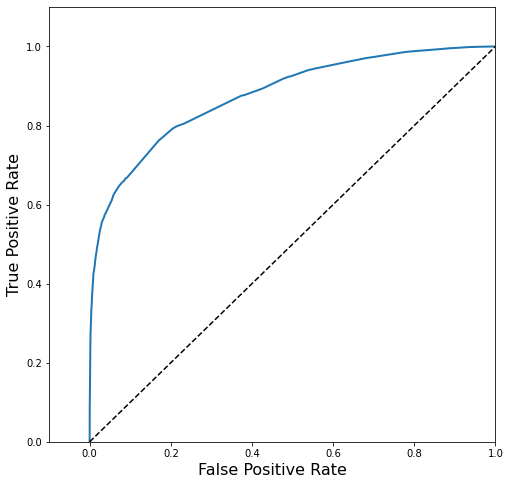

In [133]:
# plot the roc curve
plt.figure(figsize=(8,8))

# plot the curve
plt.plot(fpr,tpr,linewidth=2)

# plot what you'd get with random guessing
plt.plot([0,1],[0,1],'k--')

plt.axis([-0.1,1,0,1.1])

plt.xlabel("False Positive Rate",fontsize=16)
plt.ylabel("True Positive Rate",fontsize=16)

#Note: True Positive Rate is the same thing as sensitivity (i.e. recall)
#False positive rate is 1-specificity 

### Convert validation information and prediction to a CSV 

In [123]:
#Let's now convert this information into a csv for viewing.
X_val_1['model_pa_predictions']=y_pred
pd.DataFrame(X_val_1).to_csv("pa_predictions.csv", index = None)

In [125]:
#See the prediction for the specific prior authorization patient. 
df5=pd.read_csv('pa_predictions.csv')
df5

,dim_claim_id,dim_pa_id,bin,drug,reject_code,correct_diagnosis,tried_and_failed,contraindication,model_pa_predictions
0,966579,401911,417614,B,75.0,1,0,0,1
1,1233057,512956,417614,A,70.0,1,1,1,0
2,376172,155952,417614,B,75.0,0,1,1,1
3,453292,188009,417380,A,75.0,1,0,1,1
4,603405,250544,417740,B,70.0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
166781,421279,174683,417740,B,70.0,0,1,0,1
166782,1198211,498420,417614,B,75.0,1,1,0,1
166783,205508,85165,417614,B,75.0,0,1,0,1
166784,186139,77231,417740,B,70.0,0,0,0,0


In [135]:
#Gathering the prior authorizations approvals by reject codes. 
df5[df5.model_pa_predictions==1]['reject_code'].value_counts()

75.0    65292
70.0    44102
76.0    25793
Name: reject_code, dtype: int64

From this information, it looks like a reject code of 75 and 70 got the most approvals. 

In [129]:
#Gathering the prior authorizations denials by reject codes.
df5[df5.model_pa_predictions==0]['reject_code'].value_counts()

70.0    31361
76.0      238
Name: reject_code, dtype: int64

From this information, it looks like reject code 70 got almost all denials. Moreover, reject code 75 got no denials from this model prediction.This allows us to potentially conclude that as long as the requested medication was on the formulary, the prior authorization more than likely got approved by the insurance company. 